In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load libraries and paths

In [26]:
import sys
sys.path.append("../..")

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pymc as pm 
import arviz as az
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_population_to_classes, 
                                    convert_elevation_to_classes, 
                                    convert_slope_to_classes, 
                                    apply_encoding, 
                                    naturraumregionen_encoding, 
                                    map_to_binary)
from src.modeling.utils import temporal_train_test_split, save_model, load_model
from src.modeling.bayesian_models import create_blr, create_st_blr, create_bnn, create_st_intercept_blr
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN
from src.visualization import (plot_st_sample_size_distribution, plot_performance_over_test_years)


In [28]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [29]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)

### Data Cleaning & Preparation

In [30]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

training_data['season'] = training_data['date'].dt.month.apply(lambda x: (
    3 if x in [12, 1, 2] else
    0 if x in [3, 4, 5] else
    1 if x in [6, 7, 8] else
    2 
))

# encode features into predefined classes
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["elevation_encoded"] = training_data["elevation"].apply(convert_elevation_to_classes)
training_data["slope_encoded"] = training_data["slope"].apply(convert_slope_to_classes)
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["population_encoded"] = training_data["population_density"].apply(convert_population_to_classes)

# binarize features
training_data["farmyard_density_bin"] = training_data["farmyard_density"].apply(map_to_binary)
training_data["forestroad_density_bin"] = training_data["forestroad_density"].apply(map_to_binary)
training_data["railway_density_bin"] = training_data["railway_density"].apply(map_to_binary)
training_data["hikingtrail_density_bin"] = training_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

/tmp/ipykernel_9963/2105497721.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data["forest_type"].fillna(6, inplace=True)


### Temporal train test split

In [31]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

print("The following gives us the split date:")
print(X_train_unprocessed.date.max())
print(X_test_unprocessed.date.min())

The following gives us the split date:
2016-05-09 00:00:00
2016-05-11 00:00:00


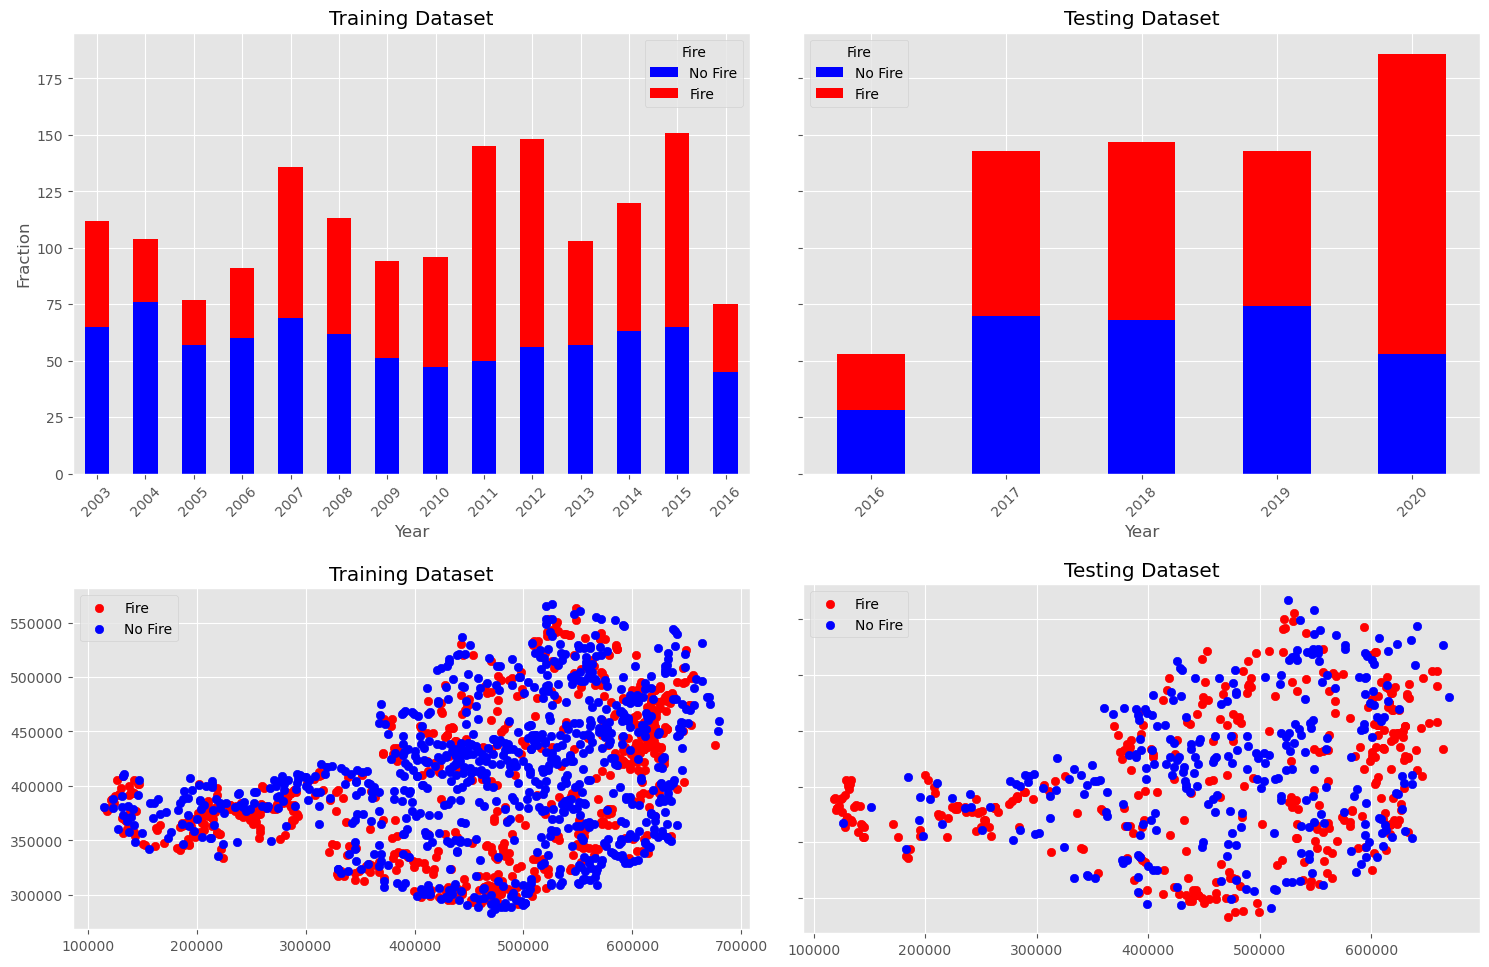

In [32]:
# Plotting the distribution of fire and no-fire samples for train and test set
plot_st_sample_size_distribution(X_train_unprocessed, X_test_unprocessed, r"../../results/train_test_distribution.png")

### Feature Preprocessing

In [33]:
# feature processing for BLR and ST_BLR
preprocessor_blr = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ["ffmc"])
    ],
    remainder='drop',
)

preprocessor_blr.fit(X_train_unprocessed)
train_ffmc_scaled = preprocessor_blr.transform(X_train_unprocessed)
test_ffmc_scaled = preprocessor_blr.transform(X_test_unprocessed)

X_train = X_train_unprocessed.copy()
X_test = X_test_unprocessed.copy()
X_train["ffmc"] = train_ffmc_scaled
X_test["ffmc"] = test_ffmc_scaled


features_to_scale = ["ffmc"]
features_to_ohe = ["elevation_encoded", "slope_encoded", "aspect_encoded", 
                   "population_encoded", "farmyard_density_bin", "forestroad_density_bin", 
                   "railway_density_bin", "hikingtrail_density_bin", "forest_type"]

preprocessor_bnn = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_to_ohe)
    ],
    remainder='drop',
)

# scaler
preprocessor_bnn.fit(X_train_unprocessed)
X_train_bnn = preprocessor_bnn.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor_bnn.transform(X_test_unprocessed)

### Modeling

In [34]:
coords = {"elevation_classes": [0, 1, 2, 3, 4, 5], 
          "slope_classes": [0, 1, 2, 3, 4], 
          "aspect_classes": [0, 1, 2, 3, 4, 5, 6, 7],
          "forest_type_classes": [0, 1, 2, 3, 4, 5, 6], 
          "population_classes": [0, 1, 2, 3, 4, 5], 
          "farmyard_density_classes": [0, 1], 
          "forestroad_density_classes": [0, 1], 
          "railway_density_classes": [0, 1], 
          "hikingtrail_density_classes": [0, 1], 
          "spatial_groups": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
          "temporal_groups": [0, 1, 2, 3]}

In [35]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr(X_train, y_train, coords)
with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample(random_seed=0)

save_model("../../models/blr.pkl", model_blr, blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 786.51


In [36]:
model_st_intercept_blr = create_st_intercept_blr(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_intercept_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_intercept_blr_idata = approx.sample(random_seed=0)

save_model("../../models/st_intercept_blr.pkl", model_st_intercept_blr, st_intercept_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 775.6


In [37]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample(random_seed=0)

save_model("../../models/st_blr.pkl", model_st_blr, st_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,237.4


In [38]:
model_bnn = create_bnn(X_train_bnn.toarray(), y_train)

with model_bnn:
    approx = pm.fit(n=20000, random_seed=0)
    bnn_idata = approx.sample(random_seed=0)

save_model("../../models/bnn.pkl", model_bnn, bnn_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,076.8


### Out-of-sample prediction

In [39]:
# open saved models
model_blr, idata_blr = load_model("../../models/blr.pkl")
model_st_blr, idata_st_blr = load_model("../../models/st_blr.pkl")
model_st_intercept_blr, idata_st_intercept_blr = load_model("../../models/st_intercept_blr.pkl")
model_bnn, idata_bnn = load_model("../../models/bnn.pkl")

In [40]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation_encoded,
    "slope": X_test.slope_encoded,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density_bin,
    "railway_density": X_test.railway_density_bin,
    "hikingtrail_density": X_test.hikingtrail_density_bin,
    "farmyard_density": X_test.farmyard_density_bin,
    "population": X_test.population_encoded,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [41]:
seed = 0

# predictions for blr model
blr_prediction_obj = BinaryClassification(model_blr, idata_blr, X_new_blr, seed, "y_pred", "p", "z")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

# predictions for st_intercept_blr model
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, idata_st_intercept_blr, X_new_st_blr, seed, "y_pred", "p", "z")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, idata_st_blr, X_new_st_blr, seed, "y_pred", "p", "z")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, idata_bnn, X_test_bnn.toarray(), seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

### Analyze & Visualize results

#### Calculate overall model performance

In [106]:

print("BLR Accuracy: ", round(accuracy_score(y_test, blr_preds.y_pred), 2))
print("BLR Precision: ", round(precision_score(y_test, blr_preds.y_pred), 2))
print("BLR Recall: ", round(recall_score(y_test, blr_preds.y_pred), 2))
print("BLR F1 Score", round(f1_score(y_test, blr_preds.y_pred), 2))

print("---------------------------------")

print("ST Intercept BLR Accuracy: ", round(accuracy_score(y_test, st_intercept_blr_preds.y_pred), 2))
print("ST Intercept BLR Precision: ", round(precision_score(y_test, st_intercept_blr_preds.y_pred), 2))
print("ST Intercept BLR  Recall: ", round(recall_score(y_test, st_intercept_blr_preds.y_pred), 2))
print("ST Intercept BLR  F1 Score: ", round(f1_score(y_test, st_intercept_blr_preds.y_pred), 2))


print("---------------------------------")

print("ST BLR Accuracy: ", round(accuracy_score(y_test, st_blr_preds.y_pred), 2))
print("ST BLR Precision: ", round(precision_score(y_test, st_blr_preds.y_pred), 2))
print("ST BLR Recall: ", round(recall_score(y_test, st_blr_preds.y_pred), 2))
print("ST BLR F1 Score: ", round(f1_score(y_test, st_blr_preds.y_pred), 2))


print("---------------------------------")

print("BNN Accuracy: ", round(accuracy_score(y_test, bnn_preds.y_pred), 2))
print("BNN Precision: ", round(precision_score(y_test, bnn_preds.y_pred), 2))
print("BNN Recall: ", round(recall_score(y_test, bnn_preds.y_pred), 2))
print("BNN F1 Score: ", round(f1_score(y_test, bnn_preds.y_pred), 2))



BLR Accuracy:  0.77
BLR Precision:  0.83
BLR Recall:  0.75
BLR F1 Score 0.79
---------------------------------
ST Intercept BLR Accuracy:  0.77
ST Intercept BLR Precision:  0.82
ST Intercept BLR  Recall:  0.75
ST Intercept BLR  F1 Score:  0.79
---------------------------------
ST BLR Accuracy:  0.75
ST BLR Precision:  0.79
ST BLR Recall:  0.76
ST BLR F1 Score:  0.78
---------------------------------
BNN Accuracy:  0.77
BNN Precision:  0.8
BNN Recall:  0.79
BNN F1 Score:  0.8


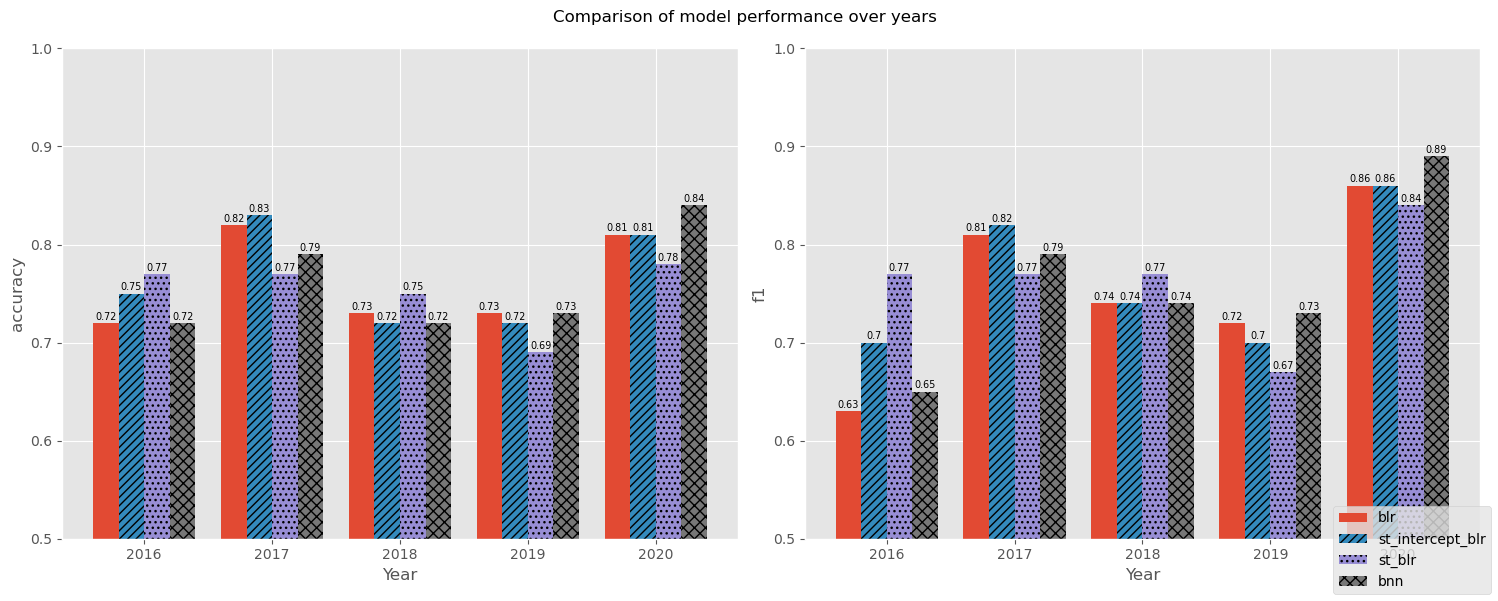

In [43]:
# Performance (Accuracy & F1) over years and across seasons (4 plots)
model_preds = [(blr_preds, "blr"), (st_intercept_blr_preds, "st_intercept_blr"), (st_blr_preds, "st_blr"), (bnn_preds, "bnn")]
plot_performance_over_test_years(model_preds, X_test, y_test, "../../results/model_performance_over_years.png")

#### Plot spatio-temporal model performance

/tmp/ipykernel_9963/1527691737.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds_spatial_grouped = preds.groupby(["spatial_group"]).apply(calculate_st_metrics).reset_index()
/tmp/ipykernel_9963/1527691737.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds_temporal_grouped = preds.groupby(["temporal_group"]).apply(calculate_st_metrics).reset_index()


,temporal_group,accuracy,f1,sample_size
0,0,0.766756,0.800000,373.0
1,1,0.731250,0.736196,160.0
2,2,0.800000,0.777778,60.0
3,3,0.835443,0.826667,79.0


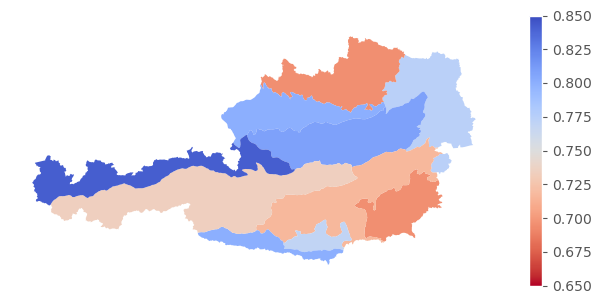

In [44]:
spatial_groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
temporal_groups = [0, 1, 2, 3]
naturraumregionen["EINHEIT_encoded"] = naturraumregionen["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)

#preds = st_intercept_blr_preds.copy()
preds = st_intercept_blr_preds.copy()

preds["spatial_group"] = X_test.naturraumregionen_encoded.values
preds["temporal_group"] = X_test.season.values
preds["y_true"] = y_test.values

def calculate_st_metrics(group):
    accuracy = accuracy_score(group['y_true'], group['y_pred'])
    f1 = f1_score(group['y_true'], group['y_pred'])
    sample_size = len(group)
    return pd.Series({'accuracy': accuracy, 'f1': f1, 'sample_size': sample_size})

preds_spatial_grouped = preds.groupby(["spatial_group"]).apply(calculate_st_metrics).reset_index()

gdf = pd.merge(naturraumregionen, preds_spatial_grouped, left_on="EINHEIT_encoded", right_on="spatial_group")
gdf.plot(column="accuracy", cmap="coolwarm_r", vmin=0.65, vmax=0.85, legend=True, legend_kwds={"shrink":0.6} )
plt.axis("off")
plt.tight_layout()
plt.savefig("../../results/model_performance_regions_blr.png")

preds_temporal_grouped = preds.groupby(["temporal_group"]).apply(calculate_st_metrics).reset_index()
preds_temporal_grouped


#### Uncertainty Quantification

In the varying intercept logistic regression model, the following assumptions are made:

**Consistent Feature Relationships**: The relationship between the predictor variables (features) and the risk of fire ignition is assumed to be consistent across different seasons and spatial regions. This implies that the effect of each predictor on the likelihood of fire ignition is uniform throughout the study area and time periods.

**Spatio-Temporal Variability**: While the relationships between features and fire ignition risk are consistent, there are assumed to be unobserved factors that vary across both spatial regions and seasons. These unobserved factors contribute to differences in fire ignition risk that are not captured by the predictor variables. To account for this, the model includes a varying intercept that allows for regional and seasonal variations in the baseline risk of fire ignition.

**Hierarchical Structure**: The model is hierarchical, meaning that the intercepts for each region and season are treated as random effects. This hierarchical structure allows the model to borrow strength across regions and seasons, providing more robust estimates by acknowledging the nested nature of the data.

**Intercept Variation**: The varying intercepts capture the unique baseline level of fire ignition risk for each region-season combination, reflecting the influence of unobserved regional and seasonal factors. This means that the model adjusts the overall risk estimate for each region and season, accounting for systematic differences not explained by the measured features.

##### Intercept Uncertainty Regions

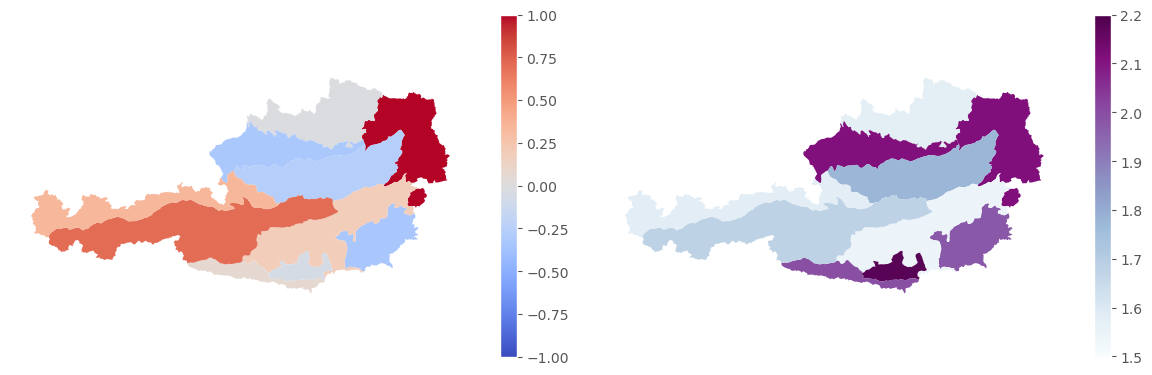

In [46]:
hdi_intercept_regions = az.hdi(idata_st_intercept_blr.posterior.intercept[:, :, :, :].values, hdi_prob=0.95).mean(axis=1)
hdi_intercept_mean = idata_st_intercept_blr.posterior.intercept[:, :, :, :].values.mean(axis=(0, 1, 3))
hdi_width = np.abs(hdi_intercept_regions[:, 1] - hdi_intercept_regions[:, 0])
hdi_regions_df = pd.DataFrame({"hdi_intercept_lower": hdi_intercept_regions[:, 0],
             "hdi_intercept_upper": hdi_intercept_regions[:, 1],
             "hdi_intercept_mean": hdi_intercept_mean,
             "hdi_intercept_width": hdi_width,
             "EINHEIT": naturraumregionen_encoding.keys()
             })
hdi_regions_gdf = pd.merge(naturraumregionen, hdi_regions_df, on="EINHEIT")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
hdi_plot1 = hdi_regions_gdf.plot(column="hdi_intercept_mean", cmap="coolwarm", legend=True, vmin=-1, vmax=1, ax=ax1, legend_kwds={"shrink": 0.6})
ax1.axis('off')
hdi_plot2 = hdi_regions_gdf.plot(column="hdi_intercept_width", cmap="BuPu", legend=True, vmin=1.5, vmax=2.2, ax=ax2, legend_kwds={"shrink": 0.6})
ax2.axis('off')

plt.tight_layout()
plt.savefig("../../results/hdi_intercept_mean_and_hdi_width.png")
plt.show()

##### Intercept Uncertainty Seasons

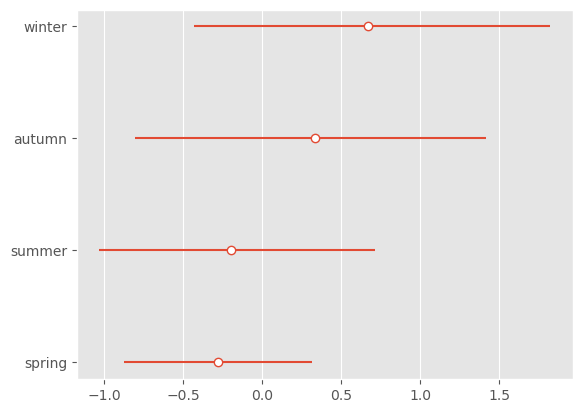

In [47]:
intercept_seasons_hdi = az.hdi(idata_st_intercept_blr.posterior.intercept[:, :, :, :].values, hdi_prob=0.95).mean(axis=0)
intercept_seasons_mean = idata_st_intercept_blr.posterior.intercept[:, :, :, :].values.mean(axis=(0, 1, 2))

error_upper = np.abs(intercept_seasons_hdi[:, 1] - intercept_seasons_mean)
error_lower = np.abs(intercept_seasons_hdi[:, 0] - intercept_seasons_mean)
plt.errorbar(x=intercept_seasons_mean, y=["spring", "summer", "autumn", "winter"], xerr=np.array([error_lower, error_upper]), fmt='o', markerfacecolor='white')
plt.grid(axis='y', which='both', linestyle='')
plt.savefig("../../results/hdi_intercept_mean_and_hdi_seasons.png")

In [48]:
var_hdi = az.hdi(idata_st_intercept_blr.posterior["beta_ffmc"], hdi_prob=0.95).beta_ffmc.values
var_mean = idata_st_intercept_blr.posterior["beta_ffmc"][:, :].values.mean(axis=(0, 1))
error_upper = np.abs(var_hdi[1] - var_mean)
error_lower = np.abs(var_hdi[0] - var_mean)
print(error_upper)

0.30400539914619173


##### Feature Coefficients & Uncertainty

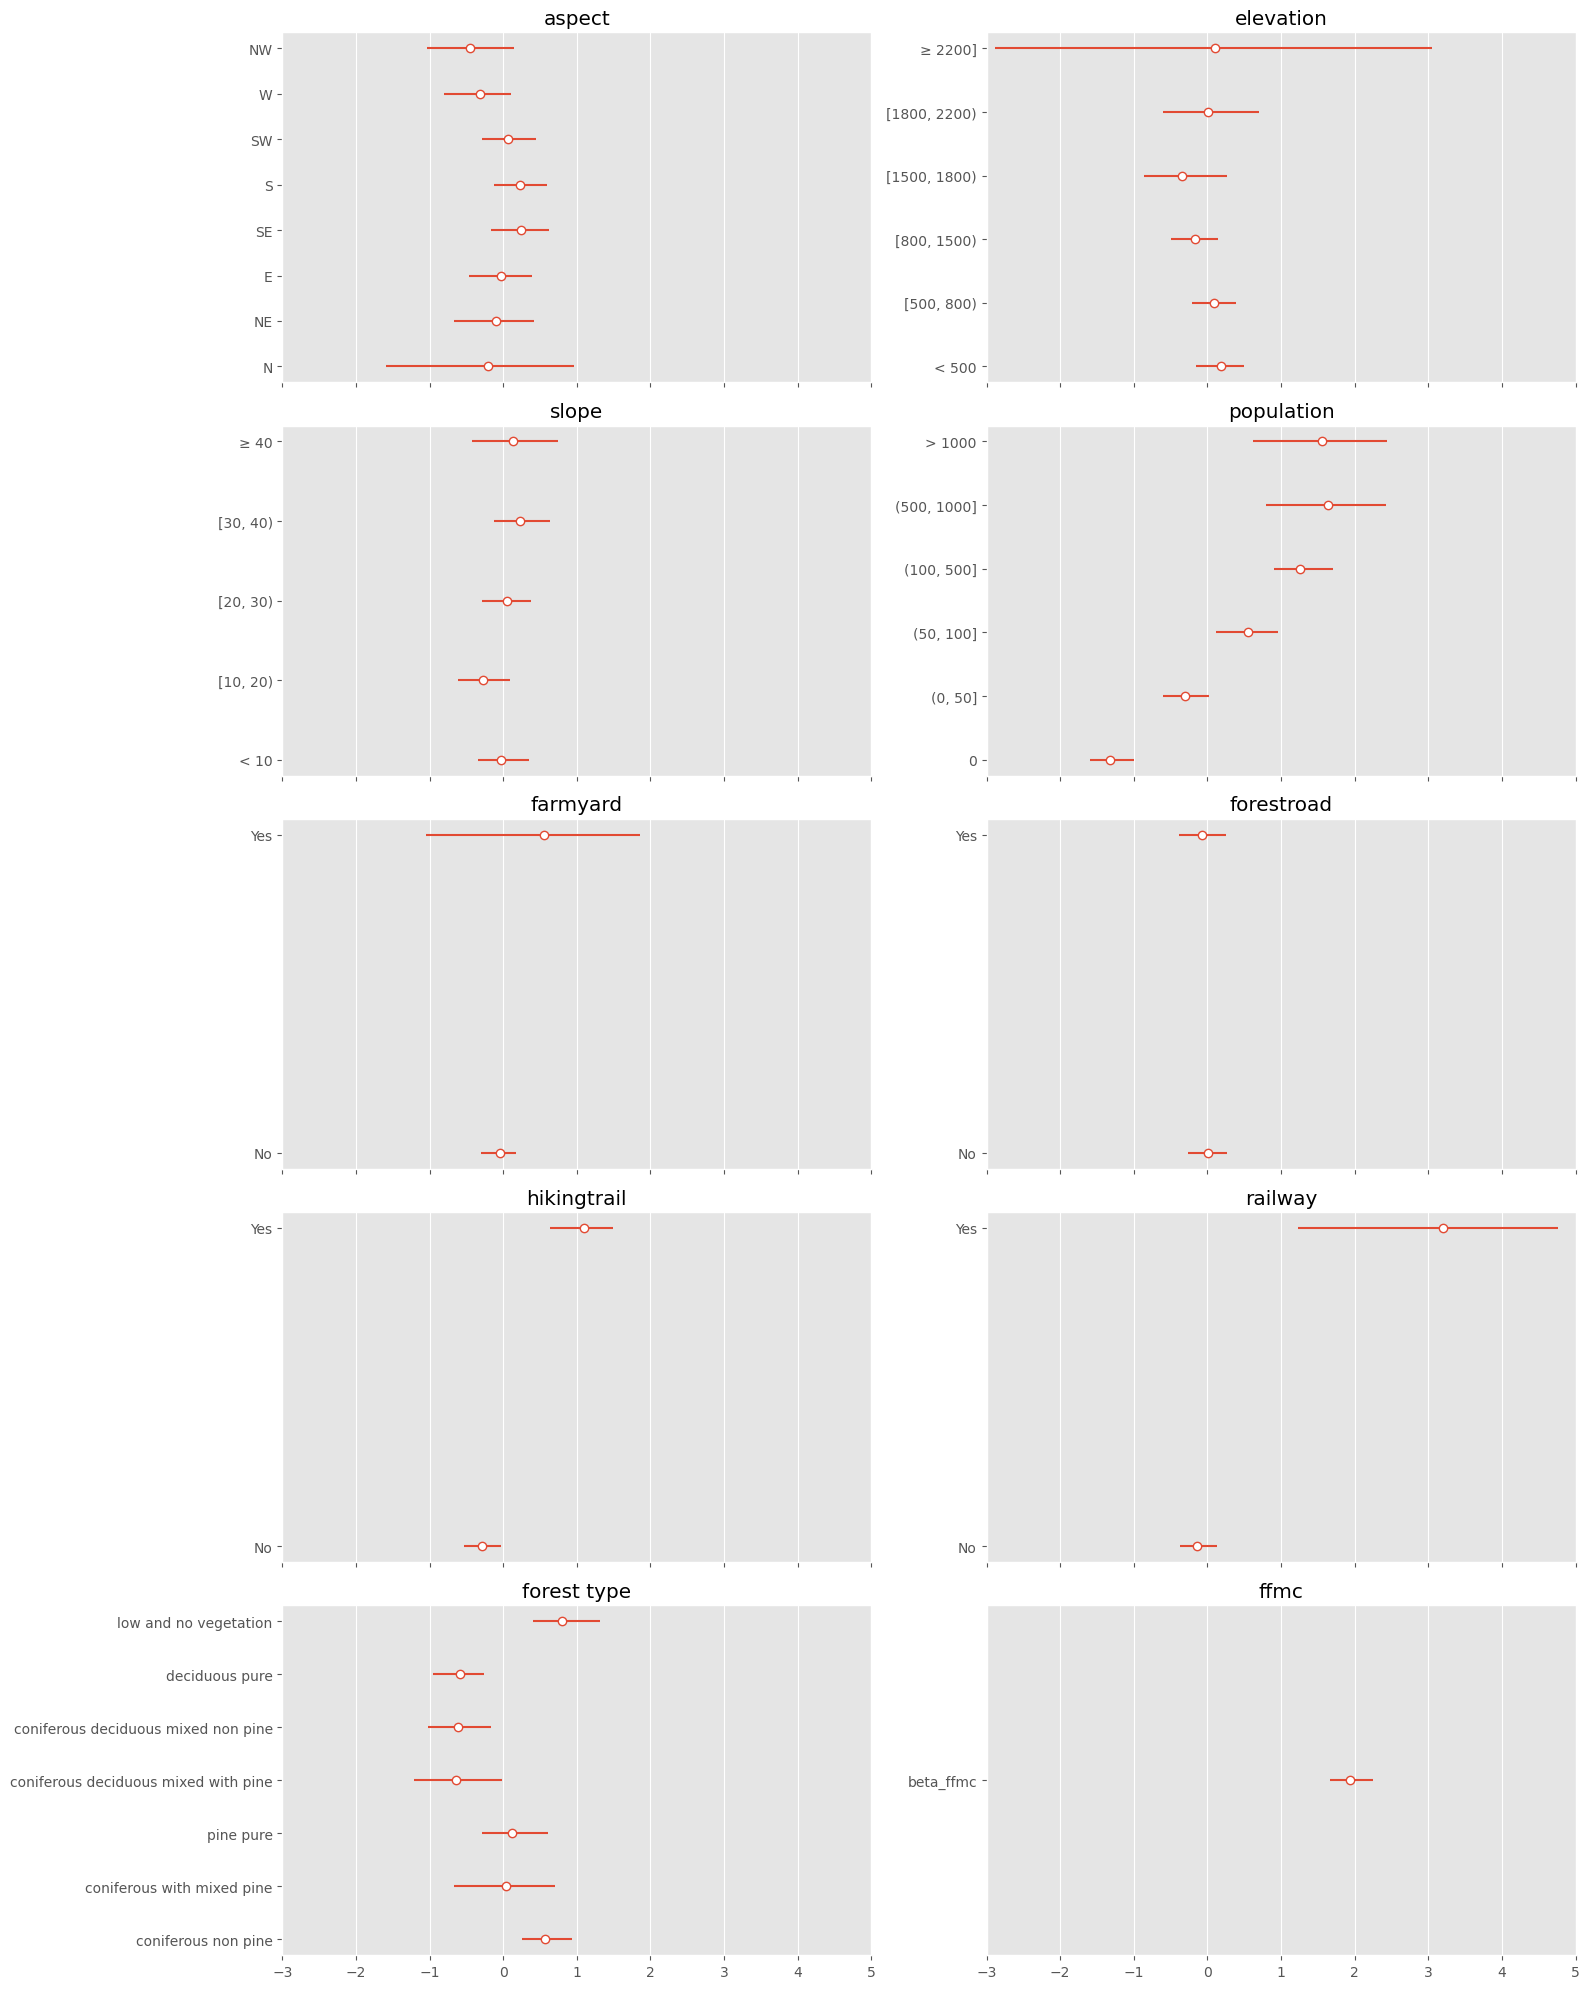

In [50]:
var_dict = {
    "beta_aspect": ("aspect", ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]),
    "beta_elevation": ("elevation", ["< 500", "[500, 800)", "[800, 1500)", "[1500, 1800)", "[1800, 2200)", "≥ 2200]"]),
    "beta_slope": ("slope", ["< 10", "[10, 20)", "[20, 30)", "[30, 40)", "≥ 40"]),
    "beta_population": ("population", ["0", "(0, 50]", "(50, 100]", "(100, 500]", "(500, 1000]", "> 1000"]),
    "beta_farmyard_density": ("farmyard", ["No", "Yes"]),
    "beta_forestroad_density": ("forestroad", ["No", "Yes"]),
    "beta_hikingtrail_density": ("hikingtrail", ["No", "Yes"]),
    "beta_railway_density": ("railway", ["No", "Yes"]),
    "beta_forest_type": ("forest type", ["coniferous non pine", "coniferous with mixed pine", "pine pure", "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"]),
    "beta_ffmc": ("ffmc", ["beta_ffmc"])
}


num_vars = len(var_dict)
fig, axes = plt.subplots(int(num_vars / 2), 2, figsize=(16, 2 * num_vars), sharex=True)

axs = axes.flatten()

for i, (var, var_classes) in enumerate(var_dict.items()):

    if var == "beta_ffmc":
        var_hdi = az.hdi(idata_st_intercept_blr.posterior["beta_ffmc"], hdi_prob=0.95).beta_ffmc.values
        var_mean = idata_st_intercept_blr.posterior["beta_ffmc"][:, :].values.mean(axis=(0, 1))
        error_upper = [np.abs(var_hdi[1] - var_mean)]
        error_lower = [np.abs(var_hdi[0] - var_mean)]
    else:
        var_hdi = az.hdi(idata_st_intercept_blr.posterior[var][:, :, :].values, hdi_prob=0.95)
        var_mean = idata_st_intercept_blr.posterior[var][:, :, :].values.mean(axis=(0, 1))
        error_upper = np.abs(var_hdi[:, 1] - var_mean)
        error_lower = np.abs(var_hdi[:, 0] - var_mean)
    
    axs[i].errorbar(x=var_mean, y=np.arange(len(var_classes[1])), 
                    xerr=np.array([error_lower, error_upper]), 
                    fmt='o', markerfacecolor='white')
    axs[i].set_xlim(-3, 5)
    axs[i].grid(axis='y', which='both', linestyle='')
    axs[i].set_yticks(np.arange(len(var_classes[1])))
    axs[i].set_yticklabels(var_classes[1])
    axs[i].set_title(var_classes[0])
    
plt.tight_layout()
plt.savefig("../../results/hdi_features_st_blr_intercept.png")
plt.show()

##### Uncertainty Quantification of selected fire events

In [51]:
relevant_columns = ['date', 'Pufferradi', 'forest_type',
                    'season', 'naturraumregionen_encoded', 'ffmc', 'ffmc_unscaled', 'elevation_encoded',
                    'slope_encoded', 'aspect_encoded', 'population_encoded',
                    'farmyard_density_bin', 'forestroad_density_bin', 'railway_density_bin',
                    'hikingtrail_density_bin', 'fire', 'y_pred', 'p_pred',
                    'p_hdi_width', 'z_pred', 'z_hdi_width']

In [52]:
z_values_train_min = idata_st_intercept_blr.posterior.z.values.min()
z_values_train_max = idata_st_intercept_blr.posterior.z.values.max()
print(z_values_train_min, z_values_train_max)

def normalize(value: float, min_value: float, max_value: float):
    return (value - min_value) / (max_value - min_value)

-18.99038705242938 12.615405713780289


In [101]:
selected_events = pd.concat([X_test.reset_index(drop=True), st_intercept_blr_preds], axis=1)

print(selected_events["z_pred"].min())
print(selected_events["z_pred"].max())

selected_events["z_pred"] = selected_events["z_pred"].apply(lambda x: normalize(x, z_values_train_min, z_values_train_max)).round(3)
selected_events["z_hdi_upper"] = selected_events["z_hdi_upper"].apply(lambda x: normalize(x, z_values_train_min, z_values_train_max))
selected_events["z_hdi_lower"] = selected_events["z_hdi_lower"].apply(lambda x: normalize(x, z_values_train_min, z_values_train_max))
selected_events["z_hdi_width"] = (selected_events["z_hdi_upper"] - selected_events["z_hdi_lower"]).round(3)
selected_events["ffmc_unscaled"] = preprocessor_blr.named_transformers_['std_scaler'].inverse_transform(selected_events.loc[:, ["ffmc"]])
selected_events["p_pred"] = selected_events["p_pred"].round(3)
selected_events["p_hdi_width"] = selected_events["p_hdi_width"].round(3)


selected_events = selected_events.loc[:, relevant_columns]

high_uncertainty_events = selected_events.sort_values(by="z_hdi_width", ascending=False).head(2)
low_uncertainty_events = selected_events.sort_values(by="z_hdi_width", ascending=True).head(2)
random_events = selected_events.sample(2, random_state=0)

selected_events_final = pd.concat([high_uncertainty_events, random_events, low_uncertainty_events])
selected_events_final

-18.50847150011698
9.227373781589256


,date,Pufferradi,forest_type,season,naturraumregionen_encoded,ffmc,ffmc_unscaled,elevation_encoded,slope_encoded,aspect_encoded,...,farmyard_density_bin,forestroad_density_bin,railway_density_bin,hikingtrail_density_bin,fire,y_pred,p_pred,p_hdi_width,z_pred,z_hdi_width
197,2018-01-03,None,0,3,3,-9.118324,24.473133,1,0,3,...,0,0,0,0,0,0,0.000,0.000,0.015,0.196
350,2019-02-23,150,2,3,0,0.202262,86.246002,0,0,3,...,0,1,1,0,1,1,0.993,0.025,0.790,0.168
582,2020-04-13,15,0,0,8,0.651695,89.224655,2,1,3,...,0,0,0,0,1,1,0.936,0.139,0.692,0.085
310,2018-08-14,400,0,1,6,0.154002,85.926155,1,4,2,...,0,0,0,0,1,0,0.484,0.661,0.599,0.101
584,2020-04-13,50,0,0,8,0.395392,87.525986,2,2,5,...,0,0,0,0,1,0,0.423,0.464,0.590,0.066
231,2018-03-27,None,0,0,9,-0.101246,84.234482,2,2,2,...,0,0,0,0,0,0,0.188,0.307,0.552,0.066


In [83]:
selected_events.elevation_encoded.unique()

array([2, 3, 1, 4, 0])

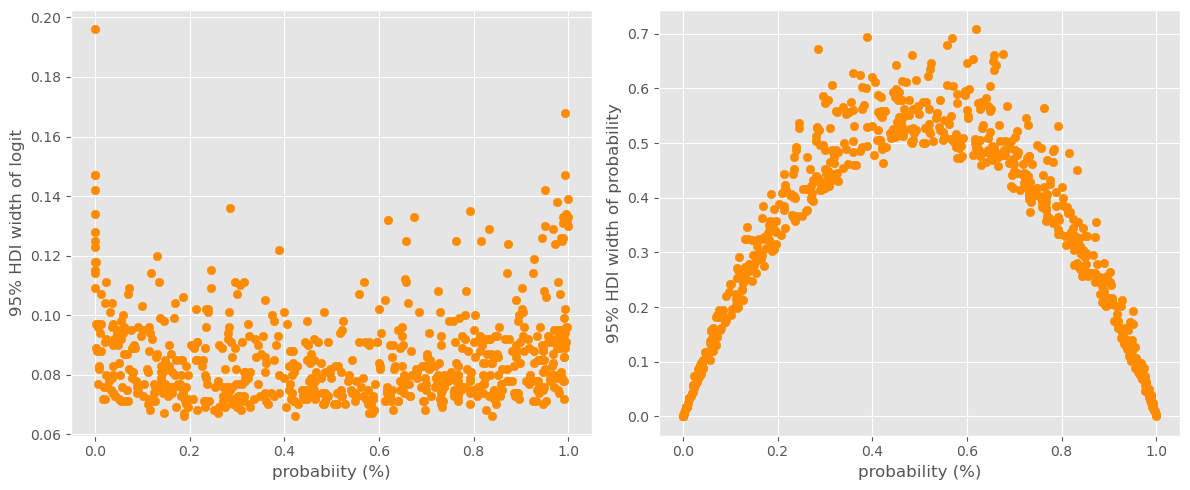

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(selected_events["p_pred"], selected_events["z_hdi_width"], color="darkorange")
ax1.set_xlabel('probabiity (%)')
ax1.set_ylabel('95% HDI width of logit')

ax2.scatter(selected_events["p_pred"], selected_events["p_hdi_width"], color="darkorange")
ax2.set_xlabel('probability (%)')
ax2.set_ylabel('95% HDI width of probability')

plt.savefig("../../results/uncertainty_risk_distribution.png")

plt.tight_layout()
plt.show()

In [ ]:
# TODO describe results in overleaf